In [601]:
!pip install pandas nltk scikit-learn

In [602]:
import pandas as pd
import nltk

In [603]:
dtypes = {
    'ArticleId': 'int32',
    'Text': 'str',
    'Category': 'category'
}
data_train = pd.read_csv('data/BBC News Train.csv', dtype=dtypes, encoding='utf-8', index_col='ArticleId')
data_test = pd.read_csv('data/BBC News Test.csv', dtype={'ArticleId': 'int32', 'Text': 'str'}, encoding='utf-8', index_col='ArticleId')
data_test_solution = pd.read_csv('data/BBC News Sample Solution.csv', dtype={'ArticleId': 'int32', 'Category': 'category'}, encoding='utf-8', index_col='ArticleId')
data_test['Category'] = data_test_solution['Category']
data = pd.concat([data_train, data_test])
data.head(10)

,Text,Category
ArticleId,,
1833,worldcom ex-boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens in ...,business
1976,lifestyle governs mobile choice faster bett...,tech
917,enron bosses in $168m payout eighteen former e...,business
1582,howard truanted to play snooker conservative...,politics
651,wales silent on grand slam talk rhys williams ...,sport
1797,french honour for director parker british film...,entertainment
2034,car giant hit by mercedes slump a slump in pro...,business


In [604]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2225 entries, 1833 to 471
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Text      2225 non-null   object  
 1   Category  2225 non-null   category
dtypes: category(1), object(1)
memory usage: 28.5+ KB


In [605]:
data.Category.value_counts()

Category
sport            493
business         483
politics         421
entertainment    420
tech             408
Name: count, dtype: int64

## Preprocessing

### Lowercasing

In [606]:
def lowercase_data(data: pd.DataFrame) -> pd.DataFrame:
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].str.lower()
    return new_data

### Punctuation Removal

In [607]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-z]+')

def remove_punctuation(data: pd.DataFrame) -> pd.DataFrame:
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].apply(tokenizer.tokenize)
    return new_data

### Stopwords Removal

In [608]:
from nltk.corpus import stopwords

nltk.download('stopwords')

def remove_stopwords(data: pd.DataFrame) -> pd.DataFrame:
    stop_words = set(stopwords.words('english'))
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].apply(lambda x: [word for word in tuple(x) if word not in stop_words and len(word) > 3])
    return new_data

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/serms/.config/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lemmatization

In [609]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
def lemmatize_data(data: pd.DataFrame) -> pd.DataFrame:
    lemmatizer = WordNetLemmatizer()
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))
    return new_data

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/serms/.config/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Stemming

In [610]:
from nltk.stem import PorterStemmer

nltk.download('punkt')
def stem_data(data: pd.DataFrame) -> pd.DataFrame:
    stemmer = PorterStemmer()
    new_data = data.copy()
    new_data['Text'] = new_data['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))
    return new_data

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/serms/.config/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Compute tf-idf

In [611]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf(data: pd.DataFrame) -> (TfidfVectorizer, pd.DataFrame):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(data['Text'])
    return vectorizer, X

In [612]:
data = lowercase_data(data)
data = remove_punctuation(data)
data = remove_stopwords(data)

data_lemmatized = lemmatize_data(data)
data_stemmed = stem_data(data)

# Using tf-idf

In [613]:
vectorizer_lemmatizer, tf_idf_lemmatized = get_tfidf(data_lemmatized)
vectorizer_stemmer, tf_idf_stemmed = get_tfidf(data_stemmed)

# Using word embeddings

In [614]:
from gensim.models import Word2Vec
import numpy as np

def get_word_embeddings(data: pd.DataFrame) -> Word2Vec:
    sentences = data['Text'].apply(lambda x: x.split())
    vector_size = len(data)
    model = Word2Vec(sentences, vector_size=vector_size, window=6, min_count=5, workers=4)
    return model

In [615]:
word_embeddings_lemmatized = get_word_embeddings(data_lemmatized)
word_embeddings_stemmed = get_word_embeddings(data_stemmed)

In [616]:
data_lemmatized['WordEmbeddings'] = data_lemmatized['Text'].apply(lambda x: Word2Vec(x, vector_size=np.min(data_lemmatized['Text'].apply(len)), window=6, min_count=5, workers=4).wv.vectors)

In [617]:
data_stemmed['WordEmbeddings'] = data_stemmed['Text'].apply(lambda x: Word2Vec(x, vector_size=np.min(data_stemmed['Text'].apply(len)), window=6, min_count=5, workers=4).wv.vectors)

In [618]:
# Average word embeddings for each document by average each column
data_lemmatized['WordEmbeddings'] = [np.mean(data_lemmatized['WordEmbeddings'][index], axis=0) for index in data_lemmatized.index]

In [619]:
# Find word using tf-idf
def find_word_tfidf(word: str, vectorizer: TfidfVectorizer, X: np.ndarray) -> np.ndarray:
    word_index = vectorizer.vocabulary_.get(word)
    if word_index is None:
        return None
    return X[:, word_index]

In [620]:
# Find word using word embeddings
def find_word_embeddings(word: str, model: Word2Vec) -> np.ndarray:
    return model.wv[word]

In [621]:
def get_ranked_documents_lemmatized(query: str) -> np.array:
    indices = find_word_tfidf(query, vectorizer_lemmatizer, tf_idf_lemmatized).toarray()
    sorted_indices = [(index, value[0]) for index, value in sorted(enumerate(indices), key=lambda x: x[1], reverse=False)]
    return np.array([data.index[index] for index, _ in sorted_indices])

In [622]:
def get_ranked_documents_stemmed(query: str) -> np.array:
    indices = find_word_tfidf(query, vectorizer_stemmer, tf_idf_stemmed).toarray()
    sorted_indices = [(index, value[0]) for index, value in sorted(enumerate(indices), key=lambda x: x[1], reverse=False)]
    return np.array([data.index[index] for index, _ in sorted_indices])

In [623]:
def get_ranked_documents_word_embeddings_lemmatized(query: str) -> np.array:
    indices = find_word_embeddings(query, word_embeddings_lemmatized)
    sorted_indices = [(index, value) for index, value in sorted(enumerate(indices), key=lambda x: x[1], reverse=False)]
    return np.array([index for index, _ in sorted_indices])

In [624]:
def get_ranked_documents_word_embeddings_stemmed(query: str) -> np.array:
    indices = find_word_embeddings(query, word_embeddings_stemmed)
    sorted_indices = [(index, value) for index, value in sorted(enumerate(indices), key=lambda x: x[1], reverse=False)]
    return np.array([index for index, _ in sorted_indices])

In [625]:
def get_document_relevance(query: str) -> np.array:
    return np.array(data['Category'].apply(lambda x: 1 if (x == query) else -1))

In [626]:
Q = []
R = []
for query in data['Category'].unique():
    Q.append(get_ranked_documents_word_embeddings_lemmatized(query))
    R.append(get_document_relevance(query))

To select a evaluation method set the variable 'method' of the cell below to any of the following values:

* 'prec_rec': draw the Precision-Recall curve for each query;
* 'r-prec': Determine the R-precision for each query;
* 'map': Calculate the Mean Average Precision;
* 'roc': Draw the Receiver-Operating-Characteristic for each query;
* 'auc': Compute the Area Under the ROC curve;
* 'all': all of the above;
* 'clear': cleans the solution space

In [627]:
len(R[1])

2225

Precision and Recall at k for k=1,...,2225
	Query 1
		P(1)=1/1=1.00,	R(1)=1/483=0.00
		P(2)=2/2=1.00,	R(2)=2/483=0.00
		P(3)=3/3=1.00,	R(3)=3/483=0.01
		P(4)=3/4=0.75,	R(4)=3/483=0.01
		P(5)=4/5=0.80,	R(5)=4/483=0.01
		P(6)=4/6=0.67,	R(6)=4/483=0.01
		P(7)=4/7=0.57,	R(7)=4/483=0.01
		P(8)=4/8=0.50,	R(8)=4/483=0.01
		P(9)=5/9=0.56,	R(9)=5/483=0.01
		P(10)=5/10=0.50,	R(10)=5/483=0.01
		P(11)=5/11=0.45,	R(11)=5/483=0.01
		P(12)=5/12=0.42,	R(12)=5/483=0.01
		P(13)=6/13=0.46,	R(13)=6/483=0.01
		P(14)=7/14=0.50,	R(14)=7/483=0.01
		P(15)=7/15=0.47,	R(15)=7/483=0.01
		P(16)=7/16=0.44,	R(16)=7/483=0.01
		P(17)=7/17=0.41,	R(17)=7/483=0.01
		P(18)=7/18=0.39,	R(18)=7/483=0.01
		P(19)=7/19=0.37,	R(19)=7/483=0.01
		P(20)=7/20=0.35,	R(20)=7/483=0.01
		P(21)=7/21=0.33,	R(21)=7/483=0.01
		P(22)=7/22=0.32,	R(22)=7/483=0.01
		P(23)=7/23=0.30,	R(23)=7/483=0.01
		P(24)=7/24=0.29,	R(24)=7/483=0.01
		P(25)=7/25=0.28,	R(25)=7/483=0.01
		P(26)=8/26=0.31,	R(26)=8/483=0.02
		P(27)=8/27=0.30,	R(27)=8/483=0.02
		P

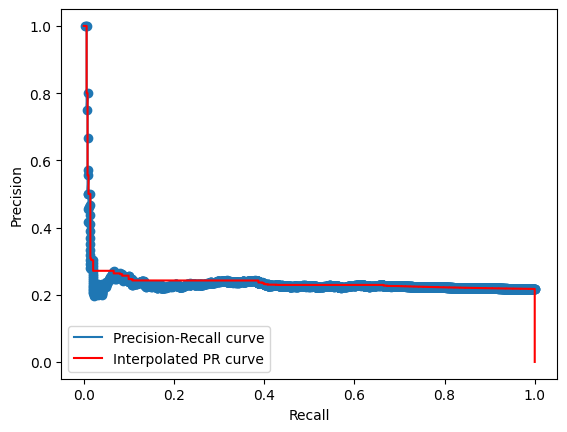

	Query 2


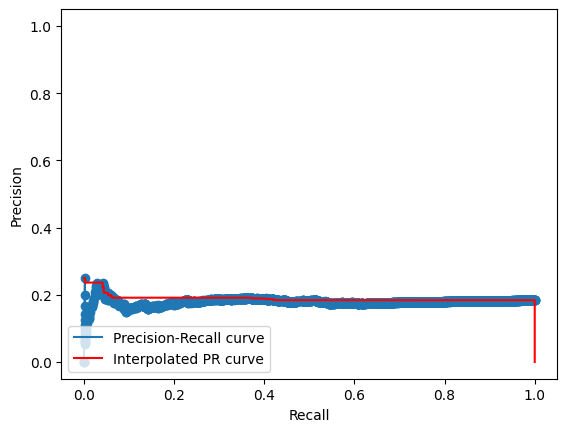

	Query 3


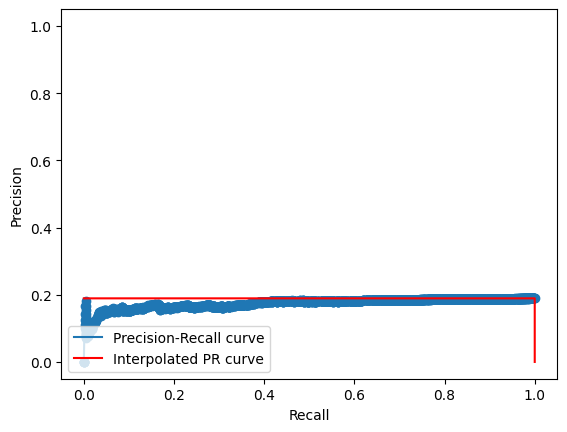

	Query 4


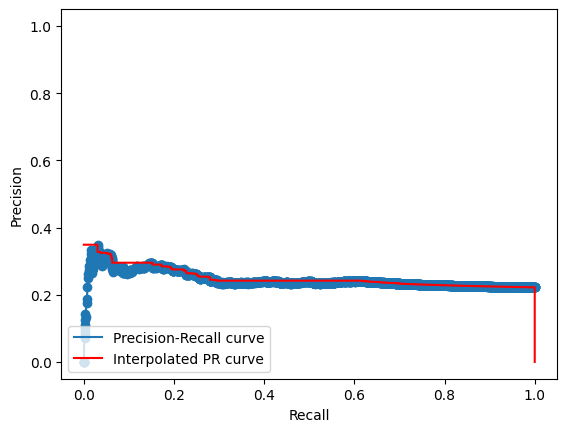

	Query 5


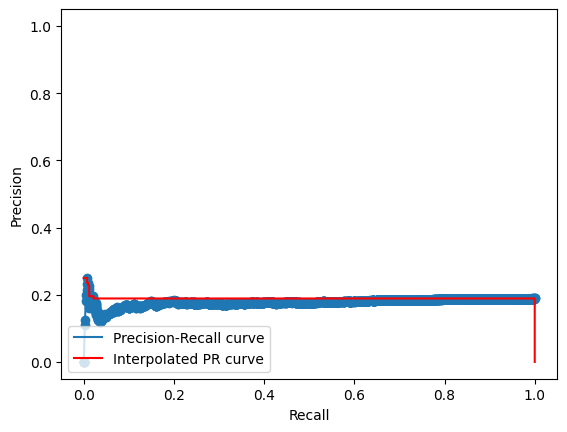

In [628]:
from evaltools import evaluate

method = 'prec_rec'
evaluate(method, Q, R)